In [12]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
from matplotlib import pyplot as pp
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm

In [60]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=1.8
muSC=10
m=.5
t=51.
alR=0.7
B=3.07
delta=.5
phi=np.pi*1.75

def mut(kx):return mu-2*t-kx**2/(2*m)-alR**2*m/2
def kF(mu):return cmath.sqrt(2*m*mu)
def a(t):return 1/cmath.sqrt(2*m*t)

def delL(phi):return delta*cmath.exp(1j*phi/2)
def delR(phi):return delta*cmath.exp(-1j*phi/2)
def nu0(m):return m/(2*np.pi)
def xiE(En):return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=1.
tR=tL

NJ=7

W=(NJ+1)*a(t)
gamma=np.pi*nu0(m)*tL**2

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [61]:
#Junction
def ke(En,B):return cmath.sqrt(2*m*(En+mu-B))
def kh(En,B):return cmath.sqrt(2*m*(-En+mu+B))

def spGe(x,xp,En,B):
    gg=np.exp(1j*ke(En,B)*abs(x-xp))-np.exp(1j*ke(En,B)*(x+xp+W))+\
    1j/np.sin(ke(En,B)*W)*np.exp(1j*ke(En,B)*W)*(np.cos(ke(En,B)*(x-xp))-np.cos(ke(En,B)*(x+xp+W)))
    return -1j*m/ke(En,B)*gg
def spGh(x,xp,En,B):
    gg=np.exp(1j*kh(En,B)*abs(x-xp))-np.exp(1j*kh(En,B)*(x+xp+W))+\
    1j/np.sin(kh(En,B)*W)*np.exp(1j*kh(En,B)*W)*(np.cos(kh(En,B)*(x-xp))-np.cos(kh(En,B)*(x+xp+W)))
    return 1j*m/kh(En,B)*gg

def gJcont(En,B):
    electronarray=[[spGe(j*a(t),i*a(t),En,B) for i in range(j,NJ+1)] for j in range(1,NJ+1)]
    holearray=[[spGh(j*a(t),i*a(t),En,B) for i in range(j,NJ+1)] for j in range(1,NJ+1)]
    listdiag=[0]*NJ
    for j in range(0,NJ):
        prediag=[[electronarray[i][j],electronarray[i][j],holearray[i][j],holearray[i][j]] for i in range(0,NJ-j)]
        newdiag=np.ndarray.tolist(np.asarray(prediag).reshape(1,4*(NJ-j))[0])
        listdiag[j]=newdiag
    gJsparse0=scipy.sparse.diags(listdiag[0:1],[0])
    gJsparseUP=scipy.sparse.diags(listdiag[1:],range(4,4*NJ,4))
    return gJsparse0+gJsparseUP+gJsparseUP.transpose()

def gJm1(En,kx,B):
    return scipy.sparse.linalg.inv(gJcont(En,B)).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(mu)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)-kx))))-1j

def gSC1m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

In [62]:
En=0

def fdetB(B):
    return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**((2*t+mu)*(NJ+2))) #norm

Bmin=0.1
Bmax=40.
Barray=[]
x0roots=np.linspace(Bmin,Bmax+0.1,np.int((Bmax-Bmin)/0.5))
#norm=max(max(mu,t,alR,delta,tL**2)**((2*t+mu)*(NJ+2)),Bmax**(4*(NJ+2)))
for i in range(len(x0roots)):
    print(i)
    x0=x0roots[i]
    solekx=opt.fsolve(fdetB,np.asarray(x0))
    if abs(fdetB(solekx))>10**-6 or solekx<=0:# or solekx>2*np.pi+0.1 :
        solekx=[]
    solekx=np.ndarray.tolist(np.around(solekx,10))
    print(solekx)
    Barray.extend(solekx)
Barray=sorted(list(set(Barray)))

0
[9.622033792]
1
[]
2
[]
3
[9.622033792]
4
[9.622033792]
5
[9.622033792]
6
[9.622033792]
7
[9.622033792]
8
[9.622033792]
9
[9.622033792]
10
[9.622033792]
11
[9.622033792]
12
[9.622033792]
13
[9.622033792]
14
[9.622033792]
15
[9.622033792]
16
[9.622033792]
17
[9.622033792]
18
[9.622033792]
19
[9.622033792]
20
[9.622033792]
21
[9.622033792]
22
[9.622033792]
23
[9.622033792]
24
[9.622033792]
25
[9.622033792]
26
[9.622033792]
27
[9.622033792]
28
[9.622033792]
29
[9.622033792]
30


RuntimeError: Factor is exactly singular

19 MISSING transitions


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


Text(0,0.5,'n')

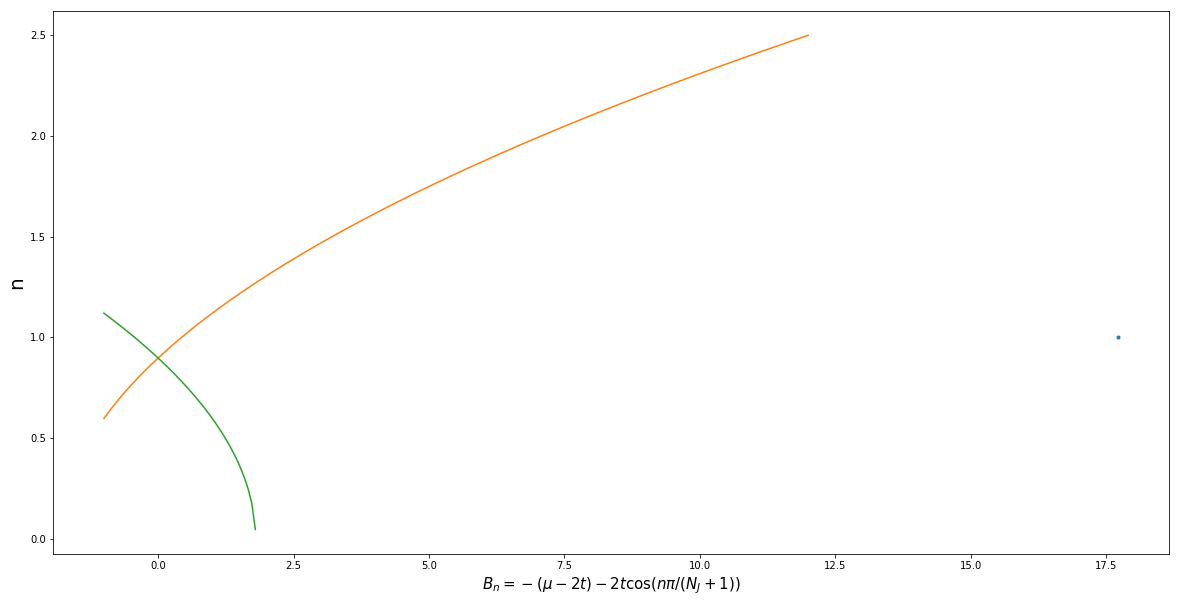

In [5]:
pp.figure(figsize=(20,10))

pp.plot(Barray,range(1,len(Barray)+1),'.')
if len(Barray)==NJ:
    print("ALL transitions shown")
else:
    print("{} MISSING transitions".format(NJ-len(Barray)))

xbarray=np.linspace(-1,12,201)
ybarray=(NJ+1)/np.pi*np.arccos((xbarray+(mu-2*t))/(-2*t))
ybarray2=(NJ+1)/np.pi*np.arccos((xbarray-(mu-2*t))/(+2*t))
pp.plot(xbarray,ybarray)
pp.plot(xbarray,ybarray2)
pp.xlabel('$B_n=-(\mu-2t)-2t \cos(n \pi/(N_J+1))$',fontsize=15)
pp.ylabel('n',fontsize=20)
#pp.axis([-0.1,11,1-0.1,10])